# 🚗 LangGraph 기반 자동차 에이전트

LangGraph를 사용하여 자동차 제어, 매뉴얼 검색, 일반 대화를 분기하는 통합 자동차 에이전트를 구현합니다.

## 🏗️ 에이전트 구조

1. **라우팅 시스템**: 사용자 입력을 분석하여 적절한 노드로 분기
2. **자동차 제어 노드**: 차량 기능 제어 관련 처리
3. **자동차 매뉴얼 노드**: Corrective RAG를 활용한 매뉴얼 검색
4. **폴백 노드**: 일반적인 대화 처리


In [95]:
# 필요한 라이브러리 import
from dotenv import load_dotenv

load_dotenv()

import os
from typing import TypedDict, List, Dict, Any, Optional, Literal
from dataclasses import dataclass
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage, SystemMessage
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_openai import ChatOpenAI
from langchain_chroma import Chroma
from langchain_openai import OpenAIEmbeddings
import json
from datetime import datetime

print("✅ 필요한 라이브러리 import 완료")

✅ 필요한 라이브러리 import 완료


In [ ]:
# LLM 및 벡터 DB 초기화
print("🚀 LLM 및 벡터 DB 초기화 중...")

# LLM 초기화
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

🚀 LLM 및 벡터 DB 초기화 중...


In [97]:
# 향상된 PDF 처리기 클래스 정의
import os
import re
import json
from pathlib import Path
from typing import List, Dict, Any, Tuple, Optional
from dataclasses import dataclass

from langchain_community.document_loaders import PyMuPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.schema import Document
from langchain_openai import OpenAIEmbeddings
from langchain_chroma import Chroma


@dataclass
class DocumentSection:
    """문서 섹션 정보를 저장하는 데이터 클래스"""

    title: str
    content: str
    page_number: int
    section_type: str  # 'header', 'content', 'table', 'list', 'warning', 'note'
    level: int  # 헤더 레벨 (1, 2, 3, ...)
    parent_section: Optional[str] = None
    metadata: Dict[str, Any] = None


class EnhancedPDFProcessor:
    """향상된 PDF 문서 구조화 처리기"""

    def __init__(self, pdf_path: str):
        self.pdf_path = pdf_path
        self.pages = []
        self.sections = []
        self.structure_info = {}

        # 자동차 매뉴얼 특화 키워드 패턴
        self.car_keywords = {
            "engine": ["엔진", "모터", "시동", "가속", "연료", "오일", "냉각수"],
            "safety": ["안전", "사고", "에어백", "벨트", "브레이크", "ABS", "ESP"],
            "comfort": ["편의", "시트", "에어컨", "히터", "온도", "조절"],
            "navigation": ["내비게이션", "GPS", "길찾기", "지도", "경로", "목적지"],
            "audio": ["오디오", "음악", "라디오", "스피커", "볼륨", "음질"],
            "lighting": ["조명", "라이트", "불빛", "전조등", "후미등", "실내등"],
            "door": ["문", "창문", "잠금", "열기", "닫기", "자동문"],
            "maintenance": ["점검", "정비", "교체", "수리", "서비스", "체크"],
            "warning": ["주의", "경고", "위험", "주의사항", "주의하세요"],
            "information": ["정보", "참고", "설명", "안내", "도움말"],
        }

        # 섹션 헤더 패턴 (한국어 자동차 매뉴얼에 특화)
        self.header_patterns = [
            r"^[0-9]+\.[0-9]*\s+[가-힣\s]+$",  # 1.1 제목
            r"^[0-9]+\s+[가-힣\s]+$",  # 1 제목
            r"^[A-Z][A-Z\s]+$",  # 대문자 제목
            r"^[가-힣]+[가-힣\s]*:$",  # 한글 제목:
            r"^[가-힣]+[가-힣\s]*\s*\([가-힣\s]+\)$",  # 한글 제목 (부제목)
        ]

        # 표 감지 패턴
        self.table_patterns = [
            r"^\s*\|.*\|.*$",  # 파이프 구분자
            r"^\s*[가-힣\s]+\s+[가-힣\s]+\s+[가-힣\s]+$",  # 3열 이상 정렬
            r"^\s*[가-힣]+.*\s+[0-9]+.*\s+[가-힣]+.*$",  # 데이터 행
        ]

        # 경고/주의사항 패턴
        self.warning_patterns = [
            r"주의[사항]*[:：]",
            r"경고[:：]",
            r"위험[:：]",
            r"주의하세요",
            r"주의[!！]",
            r"경고[!！]",
        ]


print("✅ 향상된 PDF 처리기 클래스 정의 완료")

✅ 향상된 PDF 처리기 클래스 정의 완료


In [98]:
# PDF 처리 메서드들 추가
def load_pdf(self) -> List[Document]:
    """PDF 파일을 로드합니다."""
    print(f"📄 PDF 파일 로딩 중: {self.pdf_path}")
    loader = PyMuPDFLoader(self.pdf_path)
    self.pages = loader.load()
    print(f"✅ {len(self.pages)}개 페이지 로드 완료")
    return self.pages


def detect_section_type(self, content: str) -> str:
    """텍스트 내용을 분석하여 섹션 타입을 감지합니다."""
    content_lower = content.lower()

    # 경고/주의사항 감지
    for pattern in self.warning_patterns:
        if re.search(pattern, content, re.IGNORECASE):
            return "warning"

    # 표 감지
    for pattern in self.table_patterns:
        if re.search(pattern, content, re.MULTILINE):
            return "table"

    # 리스트 감지
    if re.search(r"^\s*[•·▪▫-]\s", content, re.MULTILINE):
        return "list"

    # 헤더 감지
    for pattern in self.header_patterns:
        if re.match(pattern, content.strip()):
            return "header"

    return "content"


def extract_sections_from_page(
    self, page: Document, page_num: int
) -> List[DocumentSection]:
    """페이지에서 섹션을 추출합니다."""
    content = page.page_content
    sections = []

    # 페이지를 문단으로 분할
    paragraphs = [p.strip() for p in content.split("\n\n") if p.strip()]

    current_section = None
    section_level = 1

    for para in paragraphs:
        if not para:
            continue

        section_type = self.detect_section_type(para)

        # 헤더인 경우
        if section_type == "header":
            # 이전 섹션 저장
            if current_section:
                sections.append(current_section)

            # 새 섹션 시작
            current_section = DocumentSection(
                title=para,
                content="",
                page_number=page_num,
                section_type=section_type,
                level=section_level,
                metadata=page.metadata.copy(),
            )
            section_level += 1

        else:
            # 내용을 현재 섹션에 추가
            if current_section:
                if current_section.content:
                    current_section.content += "\n\n" + para
                else:
                    current_section.content = para
                current_section.section_type = section_type
            else:
                # 헤더가 없는 내용은 독립 섹션으로 처리
                current_section = DocumentSection(
                    title=f"페이지 {page_num} 내용",
                    content=para,
                    page_number=page_num,
                    section_type=section_type,
                    level=1,
                    metadata=page.metadata.copy(),
                )

    # 마지막 섹션 저장
    if current_section:
        sections.append(current_section)

    return sections


# 메서드를 클래스에 바인딩
EnhancedPDFProcessor.load_pdf = load_pdf
EnhancedPDFProcessor.detect_section_type = detect_section_type
EnhancedPDFProcessor.extract_sections_from_page = extract_sections_from_page

print("✅ PDF 처리 메서드 추가 완료")

✅ PDF 처리 메서드 추가 완료


In [99]:
# 구조 분석 및 청크 생성 메서드들
def analyze_document_structure(self) -> Dict[str, Any]:
    """문서의 전체 구조를 분석합니다."""
    print("🔍 문서 구조 분석 중...")

    all_sections = []
    structure_stats = {
        "total_pages": len(self.pages),
        "total_sections": 0,
        "section_types": {},
        "page_sections": {},
        "hierarchy": {},
        "tables": [],
        "warnings": [],
        "lists": [],
    }

    for i, page in enumerate(self.pages):
        page_sections = self.extract_sections_from_page(page, i + 1)
        all_sections.extend(page_sections)
        structure_stats["page_sections"][i + 1] = len(page_sections)

        for section in page_sections:
            # 섹션 타입별 통계
            section_type = section.section_type
            if section_type not in structure_stats["section_types"]:
                structure_stats["section_types"][section_type] = 0
            structure_stats["section_types"][section_type] += 1

            # 특수 섹션 수집
            if section_type == "table":
                structure_stats["tables"].append(
                    {
                        "page": i + 1,
                        "title": section.title,
                        "content": (
                            section.content[:100] + "..."
                            if len(section.content) > 100
                            else section.content
                        ),
                    }
                )
            elif section_type == "warning":
                structure_stats["warnings"].append(
                    {
                        "page": i + 1,
                        "title": section.title,
                        "content": (
                            section.content[:100] + "..."
                            if len(section.content) > 100
                            else section.content
                        ),
                    }
                )
            elif section_type == "list":
                structure_stats["lists"].append(
                    {
                        "page": i + 1,
                        "title": section.title,
                        "content": (
                            section.content[:100] + "..."
                            if len(section.content) > 100
                            else section.content
                        ),
                    }
                )

    structure_stats["total_sections"] = len(all_sections)
    self.sections = all_sections
    self.structure_info = structure_stats

    print(f"📊 총 섹션 수: {structure_stats['total_sections']}")
    print(f"📊 섹션 타입별 분포: {structure_stats['section_types']}")
    print(f"📊 표 개수: {len(structure_stats['tables'])}")
    print(f"📊 경고사항 개수: {len(structure_stats['warnings'])}")

    return structure_stats


def categorize_content(self, content: str) -> List[str]:
    """내용을 분석하여 카테고리를 분류합니다."""
    categories = []
    content_lower = content.lower()

    for category, keywords in self.car_keywords.items():
        if any(keyword in content_lower for keyword in keywords):
            categories.append(category)

    return categories if categories else ["general"]


def create_enhanced_chunks(self) -> List[Document]:
    """구조화된 섹션을 기반으로 향상된 청크를 생성합니다."""
    print("✂️ 구조화된 청크 생성 중...")

    chunks = []
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=800,  # 섹션 기반으로 크기 증가
        chunk_overlap=100,
        length_function=len,
        separators=["\n\n", "\n", ". ", " ", ""],
    )

    for i, section in enumerate(self.sections):
        # 섹션별 메타데이터 생성
        categories = self.categorize_content(section.content)

        # 섹션이 너무 크면 분할
        if len(section.content) > 1000:
            section_chunks = text_splitter.split_text(section.content)
            for j, chunk_text in enumerate(section_chunks):
                chunk_metadata = {
                    **section.metadata,
                    "section_title": section.title,
                    "section_type": section.section_type,
                    "section_level": section.level,
                    "page_number": section.page_number,
                    "categories": ", ".join(categories),
                    "chunk_index": j,
                    "total_chunks_in_section": len(section_chunks),
                    "is_structured": True,
                    "document_type": "car_manual",
                    "language": "ko",
                    "chunk_length": len(chunk_text),
                }

                chunk = Document(page_content=chunk_text, metadata=chunk_metadata)
                chunks.append(chunk)
        else:
            # 섹션 전체를 하나의 청크로 처리
            chunk_metadata = {
                **section.metadata,
                "section_title": section.title,
                "section_type": section.section_type,
                "section_level": section.level,
                "page_number": section.page_number,
                "categories": ", ".join(categories),
                "chunk_index": 0,
                "total_chunks_in_section": 1,
                "is_structured": True,
                "document_type": "car_manual",
                "language": "ko",
                "chunk_length": len(section.content),
            }

            chunk = Document(page_content=section.content, metadata=chunk_metadata)
            chunks.append(chunk)

    print(f"✅ {len(chunks)}개 구조화된 청크 생성 완료")
    return chunks


# 메서드를 클래스에 바인딩
EnhancedPDFProcessor.analyze_document_structure = analyze_document_structure
EnhancedPDFProcessor.categorize_content = categorize_content
EnhancedPDFProcessor.create_enhanced_chunks = create_enhanced_chunks

print("✅ 구조 분석 및 청크 생성 메서드 추가 완료")

✅ 구조 분석 및 청크 생성 메서드 추가 완료


In [100]:
# 벡터 데이터베이스 생성 및 메인 처리 메서드들
def create_vector_database(
    self, chunks: List[Document], collection_name: str = "car_manual"
) -> Chroma:
    """구조화된 청크를 벡터 데이터베이스에 저장합니다."""
    print("🧠 임베딩 벡터 생성 및 저장 중...")

    # 임베딩 모델 초기화
    embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

    # 배치 처리로 벡터 DB 생성
    batch_size = 50
    vector_db = None

    for i in range(0, len(chunks), batch_size):
        batch = chunks[i : i + batch_size]
        print(f"배치 {i//batch_size + 1}/{(len(chunks)-1)//batch_size + 1} 처리 중...")

        if vector_db is None:
            # 첫 번째 배치로 초기 DB 생성
            vector_db = Chroma.from_documents(
                documents=batch,
                embedding=embeddings,
                persist_directory="./car_manual_chroma_db",
                collection_name=collection_name,
            )
        else:
            # 나머지 배치 추가
            vector_db.add_documents(batch)

    print(f"✅ 벡터 데이터베이스 생성 완료")
    return vector_db


def save_structure_analysis(self, output_path: str = "structure_analysis.json"):
    """구조 분석 결과를 JSON 파일로 저장합니다."""
    analysis_data = {
        "document_info": {
            "file_path": self.pdf_path,
            "total_pages": self.structure_info.get("total_pages", 0),
            "total_sections": self.structure_info.get("total_sections", 0),
        },
        "section_analysis": self.structure_info,
        "sections": [
            {
                "title": section.title,
                "type": section.section_type,
                "level": section.level,
                "page": section.page_number,
                "content_length": len(section.content),
                "content_preview": (
                    section.content[:200] + "..."
                    if len(section.content) > 200
                    else section.content
                ),
            }
            for section in self.sections
        ],
    }

    with open(output_path, "w", encoding="utf-8") as f:
        json.dump(analysis_data, f, ensure_ascii=False, indent=2)

    print(f"📄 구조 분석 결과 저장: {output_path}")


def process_document(self) -> Tuple[Chroma, Dict[str, Any]]:
    """전체 문서 처리 파이프라인을 실행합니다."""
    print("🚗 자동차 매뉴얼 PDF 구조화 처리 시작...")

    # 1. PDF 로드
    self.load_pdf()

    # 2. 구조 분석
    structure_info = self.analyze_document_structure()

    # 3. 구조화된 청크 생성
    chunks = self.create_enhanced_chunks()

    # 4. 벡터 데이터베이스 생성
    vector_db = self.create_vector_database(chunks)

    # 5. 구조 분석 결과 저장
    self.save_structure_analysis()

    print("🎉 문서 구조화 처리 완료!")
    return vector_db, structure_info


# 메서드를 클래스에 바인딩
EnhancedPDFProcessor.create_vector_database = create_vector_database
EnhancedPDFProcessor.save_structure_analysis = save_structure_analysis
EnhancedPDFProcessor.process_document = process_document

print("✅ 벡터 DB 생성 및 메인 처리 메서드 추가 완료")

✅ 벡터 DB 생성 및 메인 처리 메서드 추가 완료


In [101]:
# 1. 기본 사용법 - 전체 문서 처리
pdf_file = "data/RS4_2025_ko_KR.pdf"

# 향상된 PDF 처리기 초기화
processor = EnhancedPDFProcessor(pdf_file)

# 전체 처리 파이프라인 실행
vector_db, structure_info = processor.process_document()

print(f"\n📊 처리 결과 요약:")
print(f"  총 페이지 수: {structure_info['total_pages']}")
print(f"  총 섹션 수: {structure_info['total_sections']}")
print(f"  섹션 타입별 분포: {structure_info['section_types']}")
print(f"  표 개수: {len(structure_info['tables'])}")
print(f"  경고사항 개수: {len(structure_info['warnings'])}")
print(f"  리스트 개수: {len(structure_info['lists'])}")

🚗 자동차 매뉴얼 PDF 구조화 처리 시작...
📄 PDF 파일 로딩 중: data/RS4_2025_ko_KR.pdf
✅ 592개 페이지 로드 완료
🔍 문서 구조 분석 중...
📊 총 섹션 수: 584
📊 섹션 타입별 분포: {'table': 559, 'content': 14, 'list': 4, 'warning': 7}
📊 표 개수: 559
📊 경고사항 개수: 7
✂️ 구조화된 청크 생성 중...
✅ 885개 구조화된 청크 생성 완료
🧠 임베딩 벡터 생성 및 저장 중...
배치 1/18 처리 중...
배치 2/18 처리 중...
배치 3/18 처리 중...
배치 4/18 처리 중...
배치 5/18 처리 중...
배치 6/18 처리 중...
배치 7/18 처리 중...
배치 8/18 처리 중...
배치 9/18 처리 중...
배치 10/18 처리 중...
배치 11/18 처리 중...
배치 12/18 처리 중...
배치 13/18 처리 중...
배치 14/18 처리 중...
배치 15/18 처리 중...
배치 16/18 처리 중...
배치 17/18 처리 중...
배치 18/18 처리 중...
✅ 벡터 데이터베이스 생성 완료
📄 구조 분석 결과 저장: structure_analysis.json
🎉 문서 구조화 처리 완료!

📊 처리 결과 요약:
  총 페이지 수: 592
  총 섹션 수: 584
  섹션 타입별 분포: {'table': 559, 'content': 14, 'list': 4, 'warning': 7}
  표 개수: 559
  경고사항 개수: 7
  리스트 개수: 4


In [ ]:
# 벡터 DB 로드
embeddings = OpenAIEmbeddings(model="text-embedding-3-small")
vector_db = Chroma(
    persist_directory="./car_manual_chroma_db",
    embedding_function=embeddings,
    collection_name="car_manual",
)

print("✅ LLM 및 벡터 DB 초기화 완료")
print(f"📊 벡터 DB 문서 수: {vector_db._collection.count()}")

In [102]:
# LangGraph 기반 Corrective RAG Agent 구현
from typing import TypedDict, List, Dict, Any, Optional, Literal
from dataclasses import dataclass
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage, SystemMessage
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from langchain_openai import ChatOpenAI
from langchain_chroma import Chroma
from langchain_openai import OpenAIEmbeddings
import json
import re
from datetime import datetime


# 상태 정의
class CorrectiveRAGState(TypedDict):
    """Corrective RAG Agent의 상태를 정의합니다."""

    # 입력
    question: str
    messages: List[BaseMessage]

    # 분석 결과
    analysis: Optional[Dict[str, Any]]
    keywords: List[str]
    complexity: str

    # 검색 및 컨텍스트
    search_results: List[Any]
    context: str
    refined_context: str

    # 답변 생성
    answer: str
    corrected_answer: str

    # 검증 및 품질
    is_correct: bool
    confidence: float
    issues: List[str]
    improvements: List[str]

    # 제어 변수
    iteration: int
    max_iterations: int
    is_satisfactory: bool
    should_continue: bool

    # 로그 및 디버깅
    correction_steps: List[Dict[str, Any]]
    error_message: Optional[str]


@dataclass
class CorrectionStep:
    """수정 단계 정보를 저장하는 데이터 클래스"""

    step_number: int
    action: str
    description: str
    result: str
    confidence: float
    timestamp: str


class LangGraphCorrectiveRAG:
    """LangGraph 기반 Corrective RAG Agent"""

    def __init__(self, vector_db: Chroma, llm: ChatOpenAI, max_iterations: int = 3):
        self.vector_db = vector_db
        self.llm = llm
        self.max_iterations = max_iterations

        # 프롬프트 템플릿들 설정
        self._setup_prompts()

        # 그래프 구성
        self.graph = self._build_graph()

    def _setup_prompts(self):
        """프롬프트 템플릿들을 설정합니다."""

        # 1. 질문 분석 프롬프트
        self.analysis_prompt = ChatPromptTemplate.from_messages(
            [
                (
                    "system",
                    """당신은 자동차 매뉴얼 전문가입니다. 사용자의 질문을 분석하여 다음 정보를 제공해주세요:

1. 질문의 핵심 의도
2. 필요한 정보 유형 (기능 설명, 조작 방법, 주의사항 등)
3. 검색해야 할 키워드
4. 예상되는 답변 복잡도 (단순/중간/복잡)

분석 결과를 JSON 형식으로 제공해주세요:
{{
    "intent": "질문의 핵심 의도",
    "info_type": "필요한 정보 유형",
    "keywords": ["키워드1", "키워드2", "키워드3"],
    "complexity": "단순/중간/복잡",
    "expected_sections": ["예상 섹션1", "예상 섹션2"]
}}""",
                ),
                ("human", "{question}"),
            ]
        )

        # 2. 컨텍스트 개선 프롬프트
        self.context_refinement_prompt = ChatPromptTemplate.from_messages(
            [
                (
                    "system",
                    """다음은 자동차 매뉴얼에서 검색된 관련 정보입니다. 
사용자 질문에 답하기 위해 이 정보를 분석하고 개선해주세요.

다음 단계를 수행해주세요:
1. 컨텍스트의 관련성 평가
2. 부족한 정보 식별
3. 추가 검색이 필요한 키워드 제안
4. 개선된 컨텍스트 구성

개선된 컨텍스트를 제공해주세요.""",
                ),
                ("human", "질문: {question}\n컨텍스트: {context}"),
            ]
        )

        # 3. 답변 생성 프롬프트
        self.answer_generation_prompt = ChatPromptTemplate.from_messages(
            [
                (
                    "system",
                    """당신은 자동차 매뉴얼 전문가입니다. 
제공된 컨텍스트를 바탕으로 사용자의 질문에 정확하고 도움이 되는 답변을 제공해주세요.

답변 작성 가이드라인:
1. 정확성: 매뉴얼의 정보를 정확히 반영
2. 명확성: 이해하기 쉽게 설명
3. 완전성: 질문에 대한 완전한 답변
4. 안전성: 안전 관련 정보는 강조
5. 구조화: 단계별로 명확하게 구성

답변을 작성해주세요:""",
                ),
                ("human", "질문: {question}\n컨텍스트: {context}"),
            ]
        )

        # 4. 답변 검증 프롬프트
        self.correction_prompt = ChatPromptTemplate.from_messages(
            [
                (
                    "system",
                    """당신은 답변 품질 검증 전문가입니다. 
제공된 답변을 검토하고 필요시 수정해주세요.

검토 기준:
1. 정확성: 정보가 올바른가?
2. 완전성: 질문에 완전히 답했는가?
3. 명확성: 이해하기 쉬운가?
4. 일관성: 논리적으로 일관된가?
5. 안전성: 안전 관련 정보가 적절히 포함되었는가?

검토 결과를 JSON 형식으로 제공해주세요:
{{
    "is_correct": true/false,
    "confidence": 0.0-1.0,
    "issues": ["문제점1", "문제점2"],
    "improvements": ["개선사항1", "개선사항2"],
    "corrected_answer": "수정된 답변"
}}""",
                ),
                ("human", "질문: {question}\n답변: {answer}\n컨텍스트: {context}"),
            ]
        )


print("✅ LangGraph 기반 Corrective RAG 클래스 정의 완료")

✅ LangGraph 기반 Corrective RAG 클래스 정의 완료


In [103]:
# LangGraph 노드들 구현
def analyze_question_node(state: CorrectiveRAGState) -> CorrectiveRAGState:
    """질문 분석 노드"""
    print(f"🔍 질문 분석 중: {state['question']}")

    try:
        # 질문 분석
        analysis_chain = (
            ChatPromptTemplate.from_messages(
                [
                    (
                        "system",
                        """당신은 자동차 매뉴얼 전문가입니다. 사용자의 질문을 분석하여 다음 정보를 제공해주세요:

1. 질문의 핵심 의도
2. 필요한 정보 유형 (기능 설명, 조작 방법, 주의사항 등)
3. 검색해야 할 키워드
4. 예상되는 답변 복잡도 (단순/중간/복잡)

분석 결과를 JSON 형식으로 제공해주세요:
{{
    "intent": "질문의 핵심 의도",
    "info_type": "필요한 정보 유형",
    "keywords": ["키워드1", "키워드2", "키워드3"],
    "complexity": "단순/중간/복잡",
    "expected_sections": ["예상 섹션1", "예상 섹션2"]
}}""",
                    ),
                    ("human", "{question}"),
                ]
            )
            | llm
            | StrOutputParser()
        )
        analysis_result = analysis_chain.invoke({"question": state["question"]})

        # JSON 파싱
        analysis = json.loads(analysis_result)

        # 수정 단계 기록
        step = CorrectionStep(
            step_number=len(state.get("correction_steps", [])) + 1,
            action="analyze",
            description="질문 분석",
            result=analysis_result,
            confidence=0.9,
            timestamp=datetime.now().isoformat(),
        )

        return {
            **state,
            "analysis": analysis,
            "keywords": analysis.get("keywords", [state["question"]]),
            "complexity": analysis.get("complexity", "단순"),
            "correction_steps": state.get("correction_steps", []) + [step.__dict__],
            "messages": state.get("messages", [])
            + [HumanMessage(content=f"질문 분석: {state['question']}")],
        }

    except Exception as e:
        print(f"❌ 질문 분석 중 오류: {e}")
        return {
            **state,
            "analysis": {
                "intent": "일반적인 질문",
                "keywords": [state["question"]],
                "complexity": "단순",
            },
            "keywords": [state["question"]],
            "complexity": "단순",
            "error_message": str(e),
        }


def search_context_node(state: CorrectiveRAGState) -> CorrectiveRAGState:
    """컨텍스트 검색 노드"""
    print(f"🔍 컨텍스트 검색 중...")

    try:
        # 키워드 기반 검색
        keywords = state.get("keywords", [state["question"]])
        search_query = " ".join(keywords)

        # 벡터 검색 (vector_db는 전역에서 접근)
        search_results = vector_db.similarity_search(search_query, k=5)

        # 컨텍스트 구성
        context_parts = []
        for i, result in enumerate(search_results):
            context_parts.append(f"[문서 {i+1}]\n{result.page_content}")

        context = "\n\n".join(context_parts)

        # 수정 단계 기록
        step = CorrectionStep(
            step_number=len(state.get("correction_steps", [])) + 1,
            action="search",
            description="컨텍스트 검색",
            result=f"검색된 문서: {len(search_results)}개",
            confidence=0.8,
            timestamp=datetime.now().isoformat(),
        )

        return {
            **state,
            "search_results": search_results,
            "context": context,
            "correction_steps": state.get("correction_steps", []) + [step.__dict__],
            "messages": state.get("messages", [])
            + [AIMessage(content=f"컨텍스트 검색 완료: {len(search_results)}개 문서")],
        }

    except Exception as e:
        print(f"❌ 컨텍스트 검색 중 오류: {e}")
        return {
            **state,
            "search_results": [],
            "context": "컨텍스트를 찾을 수 없습니다.",
            "error_message": str(e),
        }


def refine_context_node(state: CorrectiveRAGState) -> CorrectiveRAGState:
    """컨텍스트 개선 노드"""
    print(f"🔧 컨텍스트 개선 중...")

    try:
        # 컨텍스트 개선
        refinement_chain = (
            ChatPromptTemplate.from_messages(
                [
                    (
                        "system",
                        """다음은 자동차 매뉴얼에서 검색된 관련 정보입니다. 
사용자 질문에 답하기 위해 이 정보를 분석하고 개선해주세요.

다음 단계를 수행해주세요:
1. 컨텍스트의 관련성 평가
2. 부족한 정보 식별
3. 추가 검색이 필요한 키워드 제안
4. 개선된 컨텍스트 구성

개선된 컨텍스트를 제공해주세요.""",
                    ),
                    ("human", "질문: {question}\n컨텍스트: {context}"),
                ]
            )
            | llm
            | StrOutputParser()
        )
        refined_context = refinement_chain.invoke(
            {"question": state["question"], "context": state["context"]}
        )

        # 수정 단계 기록
        step = CorrectionStep(
            step_number=len(state.get("correction_steps", [])) + 1,
            action="refine",
            description="컨텍스트 개선",
            result=f"개선된 컨텍스트 길이: {len(refined_context)}자",
            confidence=0.8,
            timestamp=datetime.now().isoformat(),
        )

        return {
            **state,
            "refined_context": refined_context,
            "correction_steps": state.get("correction_steps", []) + [step.__dict__],
            "messages": state.get("messages", [])
            + [AIMessage(content="컨텍스트 개선 완료")],
        }

    except Exception as e:
        print(f"❌ 컨텍스트 개선 중 오류: {e}")
        return {**state, "refined_context": state["context"], "error_message": str(e)}


def generate_answer_node(state: CorrectiveRAGState) -> CorrectiveRAGState:
    """답변 생성 노드"""
    print(f"💭 답변 생성 중...")

    try:
        # 답변 생성
        answer_chain = (
            ChatPromptTemplate.from_messages(
                [
                    (
                        "system",
                        """당신은 자동차 매뉴얼 전문가입니다. 
제공된 컨텍스트를 바탕으로 사용자의 질문에 정확하고 도움이 되는 답변을 제공해주세요.

답변 작성 가이드라인:
1. 정확성: 매뉴얼의 정보를 정확히 반영
2. 명확성: 이해하기 쉽게 설명
3. 완전성: 질문에 대한 완전한 답변
4. 안전성: 안전 관련 정보는 강조
5. 구조화: 단계별로 명확하게 구성

답변을 작성해주세요:""",
                    ),
                    ("human", "질문: {question}\n컨텍스트: {context}"),
                ]
            )
            | llm
            | StrOutputParser()
        )
        answer = answer_chain.invoke(
            {"question": state["question"], "context": state["refined_context"]}
        )

        # 수정 단계 기록
        step = CorrectionStep(
            step_number=len(state.get("correction_steps", [])) + 1,
            action="generate",
            description="답변 생성",
            result=f"답변 길이: {len(answer)}자",
            confidence=0.7,
            timestamp=datetime.now().isoformat(),
        )

        return {
            **state,
            "answer": answer,
            "correction_steps": state.get("correction_steps", []) + [step.__dict__],
            "messages": state.get("messages", [])
            + [AIMessage(content=f"답변 생성 완료: {answer[:100]}...")],
        }

    except Exception as e:
        print(f"❌ 답변 생성 중 오류: {e}")
        return {
            **state,
            "answer": "답변을 생성할 수 없습니다.",
            "error_message": str(e),
        }


def validate_answer_node(state: CorrectiveRAGState) -> CorrectiveRAGState:
    """답변 검증 노드"""
    print(f"✅ 답변 검증 중...")

    try:
        # 답변 검증
        correction_chain = (
            ChatPromptTemplate.from_messages(
                [
                    (
                        "system",
                        """당신은 답변 품질 검증 전문가입니다. 
제공된 답변을 검토하고 필요시 수정해주세요.

검토 기준:
1. 정확성: 정보가 올바른가?
2. 완전성: 질문에 완전히 답했는가?
3. 명확성: 이해하기 쉬운가?
4. 일관성: 논리적으로 일관된가?
5. 안전성: 안전 관련 정보가 적절히 포함되었는가?

검토 결과를 JSON 형식으로 제공해주세요:
{{
    "is_correct": true/false,
    "confidence": 0.0-1.0,
    "issues": ["문제점1", "문제점2"],
    "improvements": ["개선사항1", "개선사항2"],
    "corrected_answer": "수정된 답변"
}}""",
                    ),
                    ("human", "질문: {question}\n답변: {answer}\n컨텍스트: {context}"),
                ]
            )
            | llm
            | StrOutputParser()
        )
        correction_result = correction_chain.invoke(
            {
                "question": state["question"],
                "answer": state["answer"],
                "context": state["refined_context"],
            }
        )

        # JSON 파싱
        correction_data = json.loads(correction_result)

        is_correct = correction_data.get("is_correct", True)
        confidence = correction_data.get("confidence", 0.5)
        corrected_answer = correction_data.get("corrected_answer", state["answer"])
        issues = correction_data.get("issues", [])
        improvements = correction_data.get("improvements", [])

        # 수정 단계 기록
        step = CorrectionStep(
            step_number=len(state.get("correction_steps", [])) + 1,
            action="validate",
            description="답변 검증",
            result=f"정확성: {is_correct}, 신뢰도: {confidence:.2f}",
            confidence=confidence,
            timestamp=datetime.now().isoformat(),
        )

        return {
            **state,
            "corrected_answer": corrected_answer,
            "is_correct": is_correct,
            "confidence": confidence,
            "issues": issues,
            "improvements": improvements,
            "correction_steps": state.get("correction_steps", []) + [step.__dict__],
            "messages": state.get("messages", [])
            + [AIMessage(content=f"답변 검증 완료 - 신뢰도: {confidence:.2f}")],
        }

    except Exception as e:
        print(f"❌ 답변 검증 중 오류: {e}")
        return {
            **state,
            "corrected_answer": state["answer"],
            "is_correct": True,
            "confidence": 0.5,
            "issues": [],
            "improvements": [],
            "error_message": str(e),
        }


print("✅ LangGraph 노드들 구현 완료")

✅ LangGraph 노드들 구현 완료


In [104]:
# LangGraph 라우팅 함수들 구현
def should_continue_route(state: CorrectiveRAGState) -> Literal["continue", "end"]:
    """계속 진행할지 결정하는 라우팅 함수"""
    iteration = state.get("iteration", 0)
    max_iterations = state.get("max_iterations", 3)
    is_correct = state.get("is_correct", True)
    confidence = state.get("confidence", 0.0)

    # 최대 반복 횟수에 도달했거나 만족스러운 답변을 얻었으면 종료
    if iteration >= max_iterations or (is_correct and confidence > 0.7):
        return "end"
    else:
        return "continue"


def should_refine_route(state: CorrectiveRAGState) -> Literal["refine", "generate"]:
    """컨텍스트 개선이 필요한지 결정하는 라우팅 함수"""
    iteration = state.get("iteration", 0)
    complexity = state.get("complexity", "단순")

    # 첫 번째 반복이거나 복잡한 질문인 경우 컨텍스트 개선
    if iteration == 0 or complexity in ["중간", "복잡"]:
        return "refine"
    else:
        return "generate"


# LangGraphCorrectiveRAG 클래스에 그래프 빌드 메서드 추가
def _build_graph(self) -> StateGraph:
    """LangGraph 그래프를 구성합니다."""

    # 그래프 생성
    workflow = StateGraph(CorrectiveRAGState)

    # 노드 추가
    workflow.add_node("analyze_question", analyze_question_node)
    workflow.add_node("search_context", search_context_node)
    workflow.add_node("refine_context", refine_context_node)
    workflow.add_node("generate_answer", generate_answer_node)
    workflow.add_node("validate_answer", validate_answer_node)

    # 시작점 설정
    workflow.set_entry_point("analyze_question")

    # 엣지 추가
    workflow.add_edge("analyze_question", "search_context")

    # 조건부 라우팅: 컨텍스트 개선 여부
    workflow.add_conditional_edges(
        "search_context",
        should_refine_route,
        {"refine": "refine_context", "generate": "generate_answer"},
    )

    workflow.add_edge("refine_context", "generate_answer")
    workflow.add_edge("generate_answer", "validate_answer")

    # 조건부 라우팅: 계속 진행 여부
    workflow.add_conditional_edges(
        "validate_answer",
        should_continue_route,
        {"continue": "analyze_question", "end": END},  # 다시 분석부터 시작
    )

    return workflow.compile()


# LangGraphCorrectiveRAG 클래스에 메서드 추가
def process_question(self, question: str) -> Dict[str, Any]:
    """질문을 처리하는 메인 메서드"""
    print(f"🤖 LangGraph Corrective RAG Agent가 질문을 처리합니다: '{question}'")

    # 초기 상태 설정
    initial_state = {
        "question": question,
        "messages": [HumanMessage(content=question)],
        "analysis": None,
        "keywords": [],
        "complexity": "단순",
        "search_results": [],
        "context": "",
        "refined_context": "",
        "answer": "",
        "corrected_answer": "",
        "is_correct": False,
        "confidence": 0.0,
        "issues": [],
        "improvements": [],
        "iteration": 0,
        "max_iterations": self.max_iterations,
        "is_satisfactory": False,
        "should_continue": True,
        "correction_steps": [],
        "error_message": None,
    }

    # 그래프 실행
    try:
        final_state = self.graph.invoke(initial_state)

        # 결과 정리
        result = {
            "question": question,
            "answer": final_state.get(
                "corrected_answer", final_state.get("answer", "")
            ),
            "is_satisfactory": final_state.get("is_correct", False)
            and final_state.get("confidence", 0) > 0.7,
            "confidence": final_state.get("confidence", 0.0),
            "iterations": final_state.get("iteration", 0),
            "correction_steps": final_state.get("correction_steps", []),
            "issues": final_state.get("issues", []),
            "improvements": final_state.get("improvements", []),
            "messages": final_state.get("messages", []),
            "timestamp": datetime.now().isoformat(),
        }

        print(
            f"\n🎉 처리 완료 - 신뢰도: {result['confidence']:.2f}, 반복 횟수: {result['iterations']}"
        )

        return result

    except Exception as e:
        print(f"❌ 그래프 실행 중 오류: {e}")
        return {
            "question": question,
            "answer": "처리 중 오류가 발생했습니다.",
            "is_satisfactory": False,
            "confidence": 0.0,
            "iterations": 0,
            "correction_steps": [],
            "issues": [str(e)],
            "improvements": [],
            "messages": [],
            "timestamp": datetime.now().isoformat(),
            "error": str(e),
        }


# 클래스에 메서드 바인딩
LangGraphCorrectiveRAG._build_graph = _build_graph
LangGraphCorrectiveRAG.process_question = process_question

print("✅ LangGraph 라우팅 함수 및 그래프 구성 완료")

✅ LangGraph 라우팅 함수 및 그래프 구성 완료


🚀 LangGraph Corrective RAG Agent 초기화 중...
✅ LangGraph Corrective RAG Agent 초기화 완료
📊 벡터 DB 문서 수: 3540
🔄 최대 반복 횟수: 3


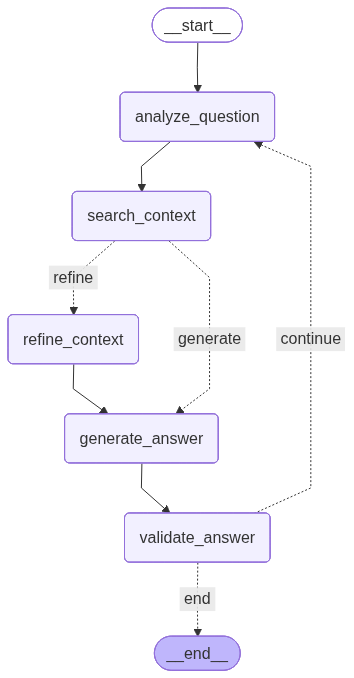

In [ ]:
# LangGraph Corrective RAG Agent 초기화 및 테스트
print("🚀 LangGraph Corrective RAG Agent 초기화 중...")

# 기존 벡터 DB 로드
embeddings = OpenAIEmbeddings(model="text-embedding-3-small")
vector_db = Chroma(
    persist_directory="./car_manual_chroma_db",
    embedding_function=embeddings,
    collection_name="car_manual",
)

# LangGraph Corrective RAG Agent 생성
langgraph_agent = LangGraphCorrectiveRAG(vector_db, llm, max_iterations=3)

print("✅ LangGraph Corrective RAG Agent 초기화 완료")
print(f"📊 벡터 DB 문서 수: {vector_db._collection.count()}")
print(f"🔄 최대 반복 횟수: {langgraph_agent.max_iterations}")

from IPython.display import Image, display

display(Image(langgraph_agent.graph.get_graph().draw_mermaid_png()))

In [106]:
# 자동차 에이전트 상태 정의
class CarAgentState(TypedDict):
    """자동차 에이전트의 상태를 정의합니다."""

    # 입력
    user_input: str
    messages: List[BaseMessage]

    # 라우팅 정보
    route_type: Optional[Literal["car_control", "car_manual", "fallback"]]
    confidence: float

    # 자동차 제어 관련
    control_action: Optional[str]
    control_result: Optional[str]

    # 매뉴얼 검색 관련
    search_query: Optional[str]
    search_results: List[Any]
    manual_answer: Optional[str]

    # 일반 대화 관련
    general_response: Optional[str]

    # 최종 응답
    final_response: str

    # 메타데이터
    timestamp: str
    processing_time: float
    error_message: Optional[str]


@dataclass
class CarControlAction:
    """자동차 제어 액션 정보"""

    action_type: str  # 'window', 'light', 'audio', 'heater', 'ac'
    action: str  # 'open', 'close', 'on', 'off', 'up', 'down'
    target: str  # 'front_left', 'rear_right', 'all', etc.
    value: Optional[str]  # '50%', '25°C', etc.


print("✅ 자동차 에이전트 상태 정의 완료")

✅ 자동차 에이전트 상태 정의 완료


In [121]:
# 라우팅 노드 구현
def route_input_node(state: CarAgentState) -> CarAgentState:
    """사용자 입력을 분석하여 적절한 노드로 라우팅합니다."""
    print(f"🔍 입력 분석 중: {state['user_input']}")

    try:
        # 라우팅 프롬프트
        routing_prompt = ChatPromptTemplate.from_messages(
            [
                (
                    "system",
                    """당신은 자동차 에이전트의 라우팅 시스템입니다. 
사용자의 입력을 분석하여 다음 중 하나로 분류해주세요:

1. **car_control**: 자동차 기능 제어 요청
   - 창문 열기/닫기, 조명 켜기/끄기, 오디오 조절, 에어컨/히터 조절 등
   - 키워드: "열어", "닫아", "켜", "꺼", "조절", "설정", "올려", "내려"

2. **car_manual**: 자동차 매뉴얼 검색 요청
   - 기능 설명, 사용법, 주의사항, 문제 해결 등
   - 키워드: "방법", "설명", "어떻게", "왜", "주의", "문제", "해결"

3. **fallback**: 일반적인 대화
   - 인사, 감사, 일상 대화, 자동차와 무관한 질문

분석 결과를 JSON 형식으로 제공해주세요:
{{
    "route_type": "car_control" | "car_manual" | "fallback",
    "confidence": 0.0-1.0,
    "reasoning": "분류 이유"
}}""",
                ),
                ("human", "{user_input}"),
            ]
        )

        # 라우팅 실행
        routing_chain = routing_prompt | llm | StrOutputParser()
        routing_result = routing_chain.invoke({"user_input": state["user_input"]})

        # JSON 파싱
        routing_data = json.loads(routing_result)

        print(
            f"📊 라우팅 결과: {routing_data['route_type']} (신뢰도: {routing_data['confidence']:.2f})"
        )

        return {
            **state,
            "route_type": routing_data["route_type"],
            "confidence": routing_data["confidence"],
            "messages": state.get("messages", [])
            + [HumanMessage(content=f"라우팅: {routing_data['route_type']}")],
        }

    except Exception as e:
        print(f"❌ 라우팅 중 오류: {e}")
        return {
            **state,
            "route_type": "fallback",
            "confidence": 0.5,
            "error_message": str(e),
        }


def car_control_node(state: CarAgentState) -> CarAgentState:
    """자동차 제어 노드 (JSON 파싱 오류 해결)"""
    print("🚗 자동차 제어 처리 중...")

    try:
        # 자동차 제어 프롬프트 (더 명확한 JSON 형식 요구)
        control_prompt = ChatPromptTemplate.from_messages(
            [
                (
                    "system",
                    """당신은 자동차 제어 시스템입니다. 
사용자의 요청을 분석하여 구체적인 제어 명령을 생성해주세요.

지원하는 제어 기능:
1. 창문 제어: 열기/닫기, 올리기/내리기
2. 조명 제어: 전조등, 후미등, 실내등 켜기/끄기
3. 오디오 제어: 볼륨 조절, 음원 변경
4. 온도 제어: 에어컨/히터 온도 조절
5. 시트 제어: 시트 위치 조절

반드시 다음 JSON 형식으로만 응답해주세요. 다른 텍스트는 포함하지 마세요:
{{
    "action_type": "window",
    "action": "open",
    "target": "all",
    "value": null,
    "response": "창문을 열었습니다."
}}""",
                ),
                ("human", "{user_input}"),
            ]
        )

        # 제어 명령 생성
        control_chain = control_prompt | llm | StrOutputParser()
        control_result = control_chain.invoke({"user_input": state["user_input"]})

        print(f"🔍 LLM 원본 응답: '{control_result}'")

        # 응답이 비어있는지 확인
        if not control_result or control_result.strip() == "":
            print("⚠️ LLM이 빈 응답을 반환했습니다.")
            control_data = {
                "action_type": "unknown",
                "action": "unknown",
                "target": "all",
                "value": None,
                "response": f"죄송합니다. '{state['user_input']}' 요청을 처리할 수 없습니다.",
            }
        else:
            # JSON 추출 시도 (여러 방법)
            control_data = None

            # 방법 1: 직접 JSON 파싱
            try:
                control_data = json.loads(control_result.strip())
                print("✅ 직접 JSON 파싱 성공")
            except json.JSONDecodeError:
                print("❌ 직접 JSON 파싱 실패, 정규식으로 JSON 추출 시도")

                # 방법 2: 정규식으로 JSON 추출
                import re

                json_match = re.search(r"\{.*\}", control_result, re.DOTALL)
                if json_match:
                    try:
                        json_str = json_match.group()
                        control_data = json.loads(json_str)
                        print("✅ 정규식 JSON 추출 성공")
                    except json.JSONDecodeError:
                        print("❌ 정규식 JSON 추출도 실패")

                # 방법 3: LLM에게 다시 요청
                if control_data is None:
                    print("🔄 LLM에게 JSON 형식으로 다시 요청")
                    retry_prompt = ChatPromptTemplate.from_messages(
                        [
                            (
                                "system",
                                "다음 텍스트에서 JSON 부분만 추출해서 올바른 JSON 형식으로 변환해주세요. 다른 설명은 포함하지 마세요.",
                            ),
                            ("human", control_result),
                        ]
                    )
                    retry_chain = retry_prompt | llm | StrOutputParser()
                    retry_result = retry_chain.invoke({})

                    try:
                        control_data = json.loads(retry_result.strip())
                        print("✅ 재요청 JSON 파싱 성공")
                    except json.JSONDecodeError:
                        print("❌ 재요청도 실패, 기본값 사용")
                        control_data = None

            # 모든 방법이 실패한 경우 기본값 사용
            if control_data is None:
                print("⚠️ 모든 JSON 파싱 방법 실패, 기본값 사용")
                control_data = {
                    "action_type": "unknown",
                    "action": "unknown",
                    "target": "all",
                    "value": None,
                    "response": f"죄송합니다. '{state['user_input']}' 요청을 처리할 수 없습니다.",
                }

        print(f"📊 최종 파싱된 데이터: {control_data}")

        # 필수 필드 확인 및 기본값 설정
        if "response" not in control_data or not control_data["response"]:
            control_data["response"] = f"'{state['user_input']}' 요청을 처리했습니다."
            print("⚠️ response 필드가 없어서 기본값으로 설정")

        # 시뮬레이션된 제어 실행
        control_action = f"{control_data.get('action_type', 'unknown')}_{control_data.get('action', 'unknown')}_{control_data.get('target', 'all')}"
        if control_data.get("value"):
            control_action += f"_{control_data['value']}"

        print(f"🎮 제어 명령 실행: {control_action}")
        print(f"💬 사용자 응답: {control_data['response']}")

        return {
            **state,
            "control_action": control_action,
            "control_result": control_data["response"],
            "final_response": control_data["response"],
            "messages": state.get("messages", [])
            + [AIMessage(content=f"자동차 제어: {control_data['response']}")],
        }

    except Exception as e:
        print(f"❌ 자동차 제어 중 오류: {e}")
        error_response = f"죄송합니다. 자동차 제어 중 오류가 발생했습니다: {str(e)}"
        return {
            **state,
            "control_action": "error",
            "control_result": error_response,
            "final_response": error_response,
            "error_message": str(e),
        }


print("✅ 라우팅 및 자동차 제어 노드 구현 완료")

✅ 라우팅 및 자동차 제어 노드 구현 완료


In [108]:
# 수정된 car_manual_node (기존 LangGraphCorrectiveRAG 사용)
def car_manual_node(state: CarAgentState) -> CarAgentState:
    """자동차 매뉴얼 검색 노드 (기존 LangGraphCorrectiveRAG 활용)"""
    print("📖 자동차 매뉴얼 검색 처리 중...")

    try:
        # 기존에 구현된 LangGraphCorrectiveRAG 사용
        # 노트북에서 이미 정의된 corrective_rag 인스턴스 사용
        if "corrective_rag" in globals():
            corrective_rag = corrective_rag
        else:
            # 만약 전역 변수에 없다면 새로 생성
            corrective_rag = LangGraphCorrectiveRAG(vector_db, llm, max_iterations=3)

        # Corrective RAG로 처리
        result = corrective_rag.process_question(state["user_input"])

        print(f"📝 Corrective RAG 답변 생성 완료")

        return {
            **state,
            "search_query": state["user_input"],
            "search_results": [],  # Corrective RAG 내부에서 처리됨
            "manual_answer": result["answer"],
            "final_response": result["answer"],
            "messages": state.get("messages", [])
            + [AIMessage(content=f"매뉴얼 검색: {result['answer'][:100]}...")],
        }

    except Exception as e:
        print(f"❌ 매뉴얼 검색 중 오류: {e}")
        return {
            **state,
            "search_query": state["user_input"],
            "search_results": [],
            "manual_answer": "매뉴얼 검색 중 오류가 발생했습니다.",
            "final_response": "죄송합니다. 매뉴얼 검색 중 오류가 발생했습니다.",
            "error_message": str(e),
        }


print("✅ car_manual_node가 기존 LangGraphCorrectiveRAG를 사용하도록 수정 완료")

✅ car_manual_node가 기존 LangGraphCorrectiveRAG를 사용하도록 수정 완료


In [124]:
# fallback_node 구현 (일반적인 대화 처리)
def fallback_node(state: CarAgentState) -> CarAgentState:
    """일반적인 대화를 처리하는 폴백 노드"""
    print("💬 일반 대화 처리 중...")

    try:
        # 일반 대화 프롬프트
        fallback_prompt = ChatPromptTemplate.from_messages(
            [
                (
                    "system",
                    """당신은 친근한 자동차 에이전트입니다. 
사용자와 자연스럽고 도움이 되는 대화를 나누어주세요.

대화 스타일:
1. 친근하고 정중한 톤
2. 자동차 관련 질문이면 도움을 제공
3. 일반적인 질문이면 적절히 응답
4. 필요시 자동차 기능을 안내
5. 사용자의 감정을 이해하고 공감

답변을 작성해주세요:""",
                ),
                ("human", "{user_input}"),
            ]
        )

        fallback_chain = fallback_prompt | llm | StrOutputParser()
        general_response = fallback_chain.invoke({"user_input": state["user_input"]})

        print(f"💭 일반 대화 응답 생성 완료")

        return {
            **state,
            "general_response": general_response,
            "final_response": general_response,
            "messages": state.get("messages", [])
            + [AIMessage(content=f"일반 대화: {general_response}")],
        }

    except Exception as e:
        print(f"❌ 일반 대화 처리 중 오류: {e}")
        return {
            **state,
            "general_response": "죄송합니다. 응답을 생성할 수 없습니다.",
            "final_response": "죄송합니다. 응답을 생성할 수 없습니다.",
            "error_message": str(e),
        }


print("✅ fallback_node 구현 완료")

✅ fallback_node 구현 완료


In [109]:
# 라우팅 함수 구현
def route_to_node(
    state: CarAgentState,
) -> Literal["car_control", "car_manual", "fallback"]:
    """라우팅 결과에 따라 적절한 노드로 분기합니다."""
    route_type = state.get("route_type", "fallback")
    confidence = state.get("confidence", 0.0)

    print(f"🔄 라우팅: {route_type} (신뢰도: {confidence:.2f})")

    # 신뢰도가 낮으면 폴백으로 처리
    if confidence < 0.3:
        return "fallback"

    return route_type


# LangGraph 자동차 에이전트 클래스
class LangGraphCarAgent:
    """LangGraph 기반 자동차 에이전트"""

    def __init__(self, vector_db: Chroma, llm: ChatOpenAI):
        self.vector_db = vector_db
        self.llm = llm
        self.graph = self._build_graph()

    def _build_graph(self) -> StateGraph:
        """LangGraph 그래프를 구성합니다."""

        # 그래프 생성
        workflow = StateGraph(CarAgentState)

        # 노드 추가
        workflow.add_node("route_input", route_input_node)
        workflow.add_node("car_control", car_control_node)
        workflow.add_node("car_manual", car_manual_node)
        workflow.add_node("fallback", fallback_node)

        # 시작점 설정
        workflow.set_entry_point("route_input")

        # 조건부 라우팅
        workflow.add_conditional_edges(
            "route_input",
            route_to_node,
            {
                "car_control": "car_control",
                "car_manual": "car_manual",
                "fallback": "fallback",
            },
        )

        # 모든 노드에서 종료
        workflow.add_edge("car_control", END)
        workflow.add_edge("car_manual", END)
        workflow.add_edge("fallback", END)

        return workflow.compile()

    def process_input(self, user_input: str) -> Dict[str, Any]:
        """사용자 입력을 처리합니다."""
        print(f"🤖 LangGraph 자동차 에이전트가 입력을 처리합니다: '{user_input}'")

        start_time = datetime.now()

        # 초기 상태 설정
        initial_state = {
            "user_input": user_input,
            "messages": [HumanMessage(content=user_input)],
            "route_type": None,
            "confidence": 0.0,
            "control_action": None,
            "control_result": None,
            "search_query": None,
            "search_results": [],
            "manual_answer": None,
            "general_response": None,
            "final_response": "",
            "timestamp": datetime.now().isoformat(),
            "processing_time": 0.0,
            "error_message": None,
        }

        # 그래프 실행
        try:
            final_state = self.graph.invoke(initial_state)

            end_time = datetime.now()
            processing_time = (end_time - start_time).total_seconds()

            # 결과 정리
            result = {
                "user_input": user_input,
                "route_type": final_state.get("route_type", "fallback"),
                "confidence": final_state.get("confidence", 0.0),
                "final_response": final_state.get("final_response", ""),
                "control_action": final_state.get("control_action"),
                "search_query": final_state.get("search_query"),
                "manual_answer": final_state.get("manual_answer"),
                "general_response": final_state.get("general_response"),
                "processing_time": processing_time,
                "timestamp": final_state.get("timestamp"),
                "error_message": final_state.get("error_message"),
            }

            print(
                f"\n🎉 처리 완료 - 라우팅: {result['route_type']}, 처리 시간: {processing_time:.2f}초"
            )

            return result

        except Exception as e:
            print(f"❌ 그래프 실행 중 오류: {e}")
            return {
                "user_input": user_input,
                "route_type": "error",
                "confidence": 0.0,
                "final_response": "처리 중 오류가 발생했습니다.",
                "processing_time": (datetime.now() - start_time).total_seconds(),
                "timestamp": datetime.now().isoformat(),
                "error_message": str(e),
            }


print("✅ LangGraph 자동차 에이전트 클래스 구현 완료")

✅ LangGraph 자동차 에이전트 클래스 구현 완료


🚀 LangGraph 자동차 에이전트 초기화 중...


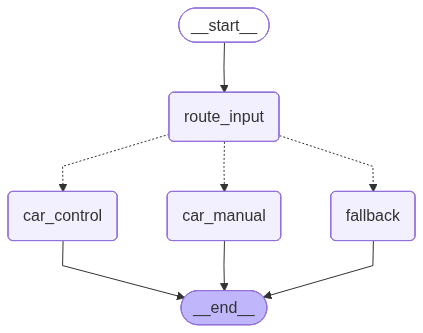

✅ 자동차 에이전트 초기화 완료

🧪 자동차 에이전트 테스트 시작

📝 테스트 1: 창문을 열어줘
----------------------------------------
🤖 LangGraph 자동차 에이전트가 입력을 처리합니다: '창문을 열어줘'
🔍 입력 분석 중: 창문을 열어줘
📊 라우팅 결과: car_control (신뢰도: 1.00)
🔄 라우팅: car_control (신뢰도: 1.00)
🚗 자동차 제어 처리 중...
🔍 LLM 원본 응답: '{
    "action_type": "window",
    "action": "open",
    "target": "all",
    "value": null,
    "response": "창문을 열었습니다."
}'
✅ 직접 JSON 파싱 성공
📊 최종 파싱된 데이터: {'action_type': 'window', 'action': 'open', 'target': 'all', 'value': None, 'response': '창문을 열었습니다.'}
🎮 제어 명령 실행: window_open_all
💬 사용자 응답: 창문을 열었습니다.

🎉 처리 완료 - 라우팅: car_control, 처리 시간: 3.32초
📊 결과:
  라우팅: car_control
  신뢰도: 1.00
  응답: 창문을 열었습니다.
  처리 시간: 3.32초
  제어 액션: window_open_all


📝 테스트 2: 엔진 시동 방법을 알려줘
----------------------------------------
🤖 LangGraph 자동차 에이전트가 입력을 처리합니다: '엔진 시동 방법을 알려줘'
🔍 입력 분석 중: 엔진 시동 방법을 알려줘
📊 라우팅 결과: car_manual (신뢰도: 0.90)
🔄 라우팅: car_manual (신뢰도: 0.90)
📖 자동차 매뉴얼 검색 처리 중...
🤖 LangGraph Corrective RAG Agent가 질문을 처리합니다: '엔진 시동 방법을 알려줘'
🔍 질문 분석 중: 엔진 시동 방법

In [128]:
# 자동차 에이전트 초기화 및 테스트
print("🚀 LangGraph 자동차 에이전트 초기화 중...")

# 자동차 에이전트 생성
car_agent = LangGraphCarAgent(vector_db, llm)

from IPython.display import Image, display

display(Image(car_agent.graph.get_graph().draw_mermaid_png()))

print("✅ 자동차 에이전트 초기화 완료")

# 테스트 입력들
test_inputs = [
    "창문을 열어줘",  # 자동차 제어
    "엔진 시동 방법을 알려줘",  # 매뉴얼 검색
    "안녕하세요",  # 일반 대화
    "에어컨 온도를 25도로 설정해줘",  # 자동차 제어
    "브레이크 오일 교체 주기는?",  # 매뉴얼 검색
    "오늘 날씨가 좋네요",  # 일반 대화
]

print("\n🧪 자동차 에이전트 테스트 시작")
print("=" * 60)

for i, test_input in enumerate(test_inputs, 1):
    print(f"\n📝 테스트 {i}: {test_input}")
    print("-" * 40)

    result = car_agent.process_input(test_input)

    print(f"📊 결과:")
    print(f"  라우팅: {result['route_type']}")
    print(f"  신뢰도: {result['confidence']:.2f}")
    print(f"  응답: {result['final_response']}")
    print(f"  처리 시간: {result['processing_time']:.2f}초")

    if result.get("control_action"):
        print(f"  제어 액션: {result['control_action']}")
    if result.get("search_query"):
        print(f"  검색 쿼리: {result['search_query']}")

    print()